In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.fft import rfft, irfft
import math
from scipy.stats import norm as normal_dist

In [2]:
def parse_wav(b):
    assert b[0:4] == b'RIFF', "Chunk ID did not match 'RIFF'"
    chunk_size = int.from_bytes(b[4:8], byteorder="little")
    assert b[8:12] == b'WAVE', "Format did not match 'WAVE'"
    assert b[12:16] == b'fmt ', "Format subchunk ID did not match 'fmt '"
    chunk1_size = int.from_bytes(b[16:20], byteorder="little")
    audio_format = int.from_bytes(b[20:22], byteorder="little")
    assert audio_format == 1, "Audio Format is not PCM (i.e. data is compressed)"
    channels = int.from_bytes(b[22:24], byteorder="little")
    sample_rate = int.from_bytes(b[24:28], byteorder="little")
    byte_rate = int.from_bytes(b[28:32], byteorder="little")
    block_align = int.from_bytes(b[32:34], byteorder="little")
    bits_per_sample = int.from_bytes(b[34:36], "little")
    assert (bits_per_sample % 8) == 0 , "bits per sample is not a multiple of 8"
    assert (sample_rate * (bits_per_sample/8) * channels == byte_rate), "byte_rate != bytes_per_sample * sample_rate * num_channels"
    # from 36 onwards, we might have additional metadata
    data_idx = 36
    while True:
        temp_chunk_id = b[data_idx: data_idx + 4]
        temp_chunk_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
        if temp_chunk_id != b'data':
            data_idx += temp_chunk_size + 8 # add 8 to include the chunk_id and chunk_size fields
        else:
            break
            
    assert b[data_idx: data_idx + 4] == b'data', "Format subchunk ID did not match 'data'"
    sample_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
    sample_begin = data_idx + 8
    assert sample_size % block_align == 0, "size of sample in bytes is not divisible by number of bytes per sample"
    return {
        "File Size": chunk_size + 8,
        "Audio Format": "PCM",
        "Channels": channels,
        "Sample Rate": sample_rate,
        "Byte Rate": byte_rate,
        "Block Align (bytes per sample)": block_align,
        "Bits Per Sample Per Channel": bits_per_sample,
        "Samples Size": sample_size,
        "Num Samples": int(sample_size/block_align),
        "File Length (seconds)": round(sample_size/(byte_rate), 3),
        "Sample Beginning Index": sample_begin,
    }

In [7]:
def get_rfft_window(samples, win_size, win_num, sample_rate, top_idx = -1):
    sample_norm = np.linalg.norm(samples[win_size*win_num:win_size*(win_num + 1)])
    yf = rfft(samples[win_size*win_num:win_size*(win_num + 1)])
    ay = np.abs(yf)
    x_axis = np.arange(len(ay)) # * (sample_rate/win_size)
    if sample_norm == 0:
        l = list(zip(x_axis, np.zeros(len(ay))))
        return (l, 1.0, samples[win_size*win_num:win_size*(win_num + 1)])
    else:
        l = list(zip(x_axis, ay))
        l.sort(key=lambda x: x[1], reverse=True)
        top = l[top_idx][1]
        l2 = []
        for i in range(len(ay)):
#             if i < 50:
#                 yf[i] = 0
            if ay[i] < top:
                yf[i] = 0
            else:
                l2.append((i, "freq {}".format(i * (sample_rate/win_size)), ay[i]))
        yinv = irfft(yf)
        l2.sort(key=lambda x: x[2], reverse=True)
        percent = 1 - (np.linalg.norm(yinv - samples[win_size*win_num:win_size*(win_num + 1)])/sample_norm)
        return (l2[:top_idx], percent, yinv)

In [8]:
f = open("ithink.wav", "rb")
bb = f.read()
f.close()

WINDOW=2048
TOP=-1
NOTES=[((' ABb B CDb DEb E FGb GAb'[2*i%24:2*i%24+2]+str(i//12)).strip(),27.5*2**(i/12)) for i in range(120)]
# NOTES = NOTES[12:108]
file_info = parse_wav(bb)
num_samples = file_info["Num Samples"]
RATE = file_info["Sample Rate"] 
samples = np.zeros(num_samples + (WINDOW - num_samples%WINDOW), dtype=np.int16)
samples[:num_samples] = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

#only use fft coefficients that correspond to diatonic notes and their harmonics 
FFT_C=[(RATE/WINDOW) * i for i in range(WINDOW//2 + 1)]
notes_to_fft = []
fft_to_notes = {}
counted = set()
for name,freq in NOTES:
    harmonic = freq
    harmonic_list = []
    while harmonic < 22050 and int(harmonic//freq) <= 16:
        min_q = 2048.0
        append = None
        for c in FFT_C:
            if c > harmonic and c/harmonic < min_q:
                min_q = c/harmonic
                append = c
            elif c <= harmonic and c != 0 and harmonic/c < min_q:
                min_q = harmonic/c
                append = c
                
        key = int(append/(RATE/WINDOW))
        harmonic_list.append((key, append))
        
        if key not in fft_to_notes.keys():
            fft_to_notes[key] = [(name, int(harmonic//freq))]
        else:
            fft_to_notes[key].append((name, int(harmonic//freq)))
            
        harmonic += freq
        counted.add(key)
    notes_to_fft.append((name, freq, harmonic_list))
assert counted == set(fft_to_notes.keys())

In [9]:
f = open("ithink-no-low-3-{}.wav".format(WINDOW), "wb")
f.write(bb[:file_info["Sample Beginning Index"]])
ffts = []
assert (len(samples) % WINDOW) == 0
ffts2 = np.zeros((len(samples)//WINDOW, WINDOW//2 + 1))
for winnum in range(len(samples)//WINDOW):
    info = get_rfft_window(samples, WINDOW, winnum, RATE, top_idx=TOP)
    f.write((info[2] * (2**15)).astype(np.int16))
    ffts.append(info[0])
    np.copyto(ffts2[winnum], np.abs(rfft(samples[WINDOW*winnum:WINDOW*(winnum + 1)])))
f.close()

percent reconstruction: 0.7941825705250407


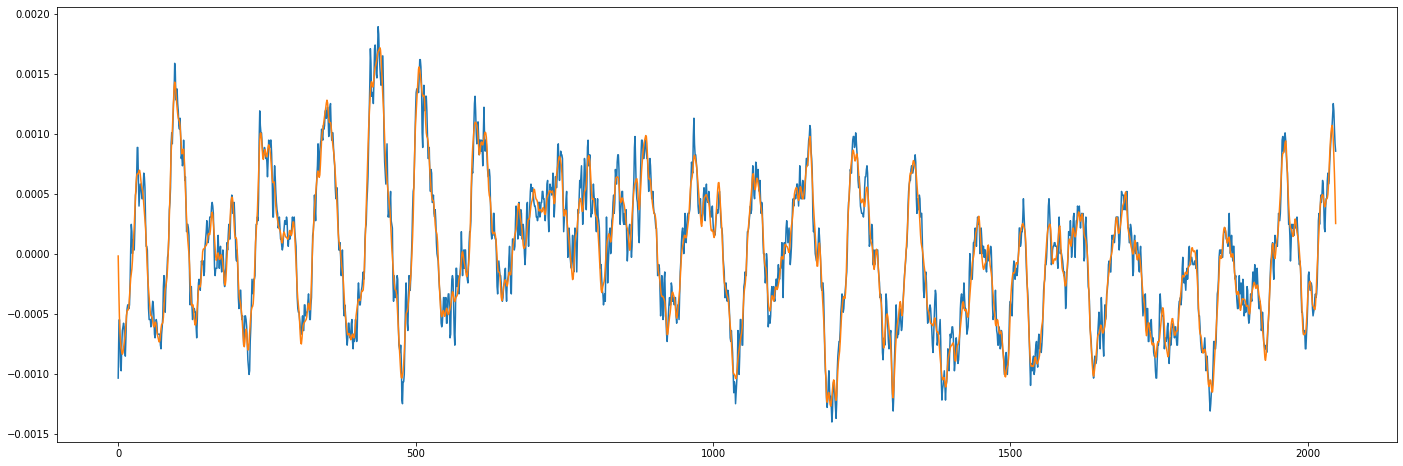

In [22]:
for winnum in range(10,11):    
    info = get_rfft_window(samples, WINDOW, winnum, RATE, top_idx=100)
    print("percent reconstruction:", info[1])
    plt.figure(figsize=(24,8))
    plt.plot(samples[WINDOW*winnum:WINDOW*(winnum + 1)])
    plt.plot(info[2])
    plt.show()


In [23]:
info[0]

[(23, 'freq 495.263671875', 0.4113568318229954),
 (1, 'freq 21.533203125', 0.3234203328508372),
 (22, 'freq 473.73046875', 0.18816023769164708),
 (25, 'freq 538.330078125', 0.18343995294839516),
 (36, 'freq 775.1953125', 0.18292165094101998),
 (17, 'freq 366.064453125', 0.16863257078756072),
 (24, 'freq 516.796875', 0.14995674791385855),
 (26, 'freq 559.86328125', 0.14216369351787642),
 (5, 'freq 107.666015625', 0.1325845264948641),
 (20, 'freq 430.6640625', 0.1312253821320997),
 (42, 'freq 904.39453125', 0.10803962883149945),
 (32, 'freq 689.0625', 0.10632525141534914),
 (31, 'freq 667.529296875', 0.10123611406480364),
 (38, 'freq 818.26171875', 0.10098674264311809),
 (18, 'freq 387.59765625', 0.09910740110687628),
 (35, 'freq 753.662109375', 0.09524619979834736),
 (12, 'freq 258.3984375', 0.0923599826630565),
 (37, 'freq 796.728515625', 0.0917757827622051),
 (30, 'freq 645.99609375', 0.09056239506528925),
 (14, 'freq 301.46484375', 0.08674900613995541),
 (16, 'freq 344.53125', 0.0865

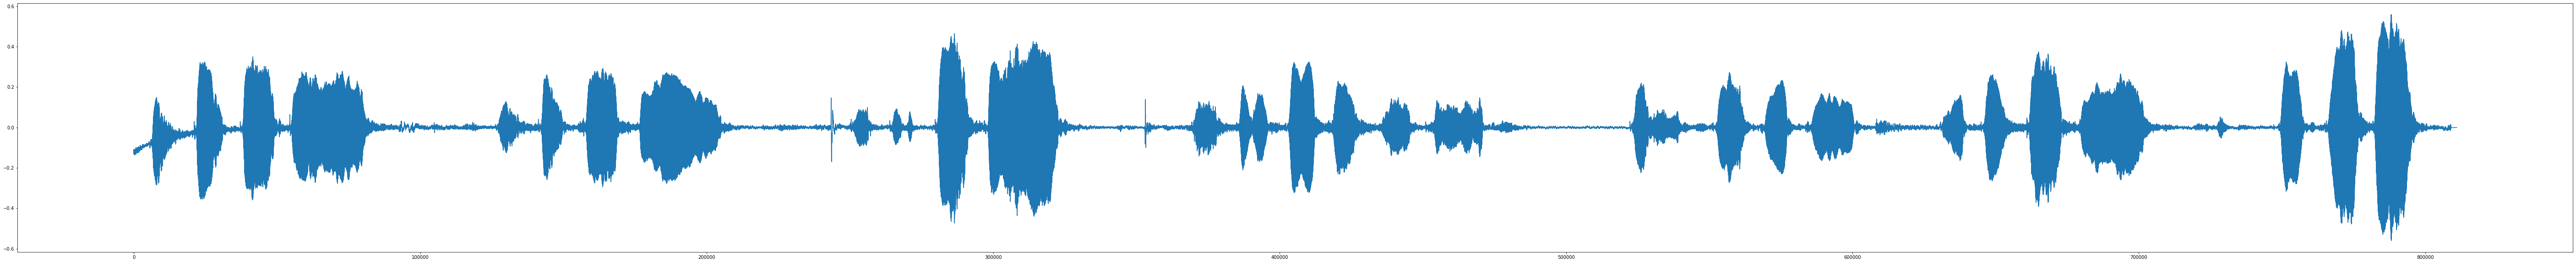

In [303]:
plt.figure(figsize=(100,10))
plt.plot(samples)


In [289]:
logs = []
for note in NOTES:
    logs.append(math.log(note[1], 2))
    print(logs[-1])

4.78135971352466
4.864693046857993
4.948026380191327
5.031359713524659
5.114693046857993
5.198026380191327
5.28135971352466
5.364693046857993
5.448026380191327
5.531359713524659
5.614693046857993
5.698026380191327
5.78135971352466
5.864693046857994
5.948026380191326
6.03135971352466
6.114693046857993
6.198026380191327
6.28135971352466
6.364693046857992
6.448026380191326
6.53135971352466
6.614693046857993
6.698026380191327
6.78135971352466
6.864693046857993
6.948026380191326
7.03135971352466
7.114693046857993
7.198026380191327
7.281359713524661
7.364693046857994
7.448026380191326
7.53135971352466
7.614693046857993
7.698026380191327
7.781359713524661
7.864693046857993
7.948026380191326
8.03135971352466
8.114693046857994
8.198026380191326
8.28135971352466
8.364693046857992
8.448026380191326
8.53135971352466
8.614693046857994
8.698026380191328
8.78135971352466
8.864693046857992
8.948026380191326
9.03135971352466
9.114693046857994
9.198026380191328
9.28135971352466
9.364693046857994
9.44802

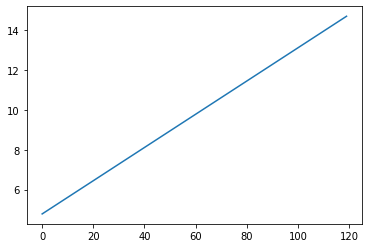

In [290]:
plt.plot(logs)

In [41]:
plan:
    for each 1024 length segment (more or less based on sample rate):
        perform fft and get strength coefficients for each frequency
        discard 0 frequency idt it matters
        for each frequency, figure out percent for which note it belongs to:
            (assume each note is gaussian, figure out percent log thingy)
            also assume harmonics (assume nth harmonic is 1/n the strength)
        then for each frequency we have a percent strength (ind freq. strength / sum of strengths)
        multiply by percent note chance
        add up all of them: get percent chance of a note

In [24]:
def near_note(note_freq, i):
    assert note_freq != 0
    assert i != 0
    mu = math.log(note_freq, 2)
    x  = math.log(i,2)
    sigma = 1/24
    ans = 2 * (1 - normal_dist().cdf(abs(x - mu)/sigma))
    assert ans >= 0
    return ans

def gen_note_near_arr(freq):
    if freq == 0:
        return np.zeros(len(NOTES))
    v = np.zeros(len(NOTES))
    for i, note in enumerate(NOTES):
        v[i] = near_note(note[1], freq)
    s = sum(v) # v only has non-negative values, so if sum is 0 then the vector is a 0 vector
    if s > 0.0:
        v /= s
    return v

# mat = np.zeros((WINDOW//2 + 1, len(NOTES)))
# for i in range(WINDOW//2 + 1):
#     f = i * (RATE/WINDOW)
#     mat[i] = gen_note_near_arr(f)

def gen_note_mat():
    mat = np.zeros((WINDOW//2 + 1, len(NOTES)))
    logs = [math.log(note[1], 2) for note in NOTES]
    sigma = 1/24
    norm = normal_dist()    
    for i in range(1, WINDOW//2 + 1): #discount frequency 0
        f = i * (RATE/WINDOW)
        x  = math.log(f,2)
        for j in range(len(NOTES)):
            mat[i][j] = 2 * (1 - norm.cdf(abs(x - logs[j])/sigma))
        s = sum(mat[i])
        if s > 0.0:
            mat[i] /= s
    return mat

# for i in range(len(mat)):
#     for j in range(len(mat[i])):
#         diff = np.abs(mat[i][j] - mat2[i][j])
#         assert diff <= 1e-8

In [25]:
mat2 = gen_note_mat()

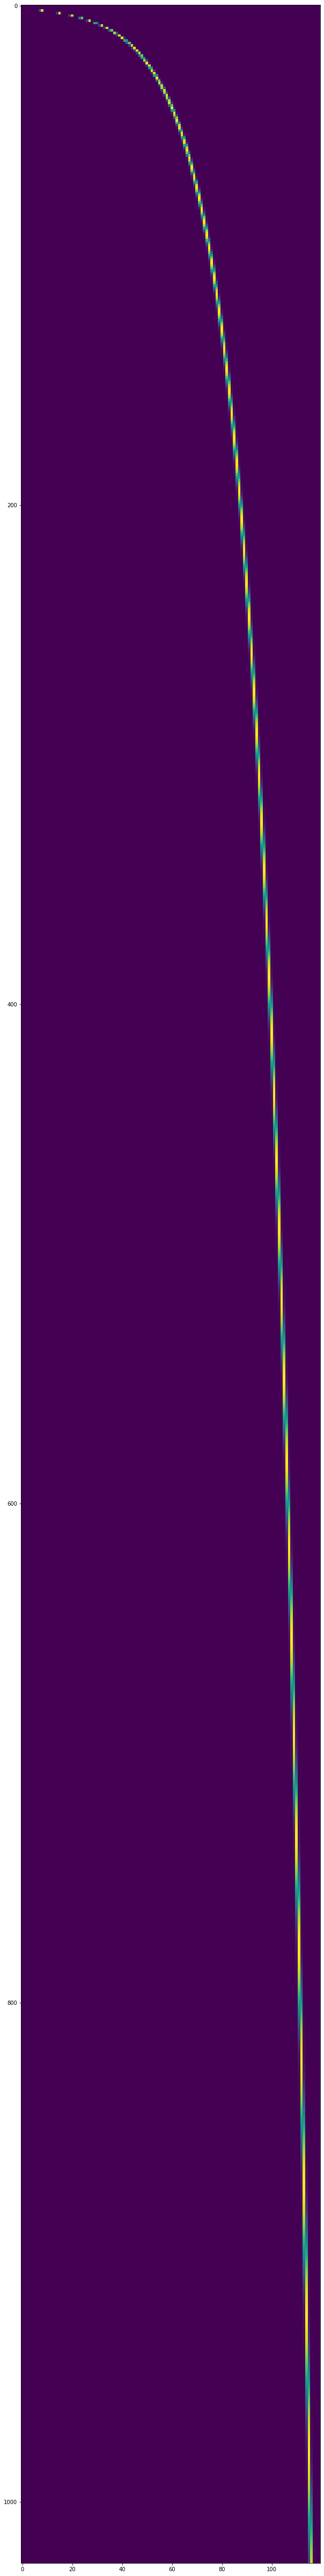

In [26]:
fig, ax = plt.subplots(figsize=(10,100))
im = ax.imshow(mat2)

In [217]:
# #Harmonic series projected onto the same octave
# l = set([1.0, 2.0])
# for x in range(1, 24):
#     s = x/(2**(int(math.log(x,2))))
#     l.add(s)
# l

In [304]:
mat2.shape

(1025, 120)

In [305]:
song = np.zeros((len(ffts2), len(NOTES)))
for i in range(len(song)):
    song[i] = np.matmul(ffts2[i], mat2)

In [306]:
song2 = np.matmul(ffts2, mat2)

<BarContainer object of 120 artists>

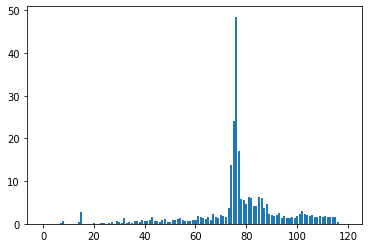

In [313]:
plt.bar(range(len(NOTES)), song[6])

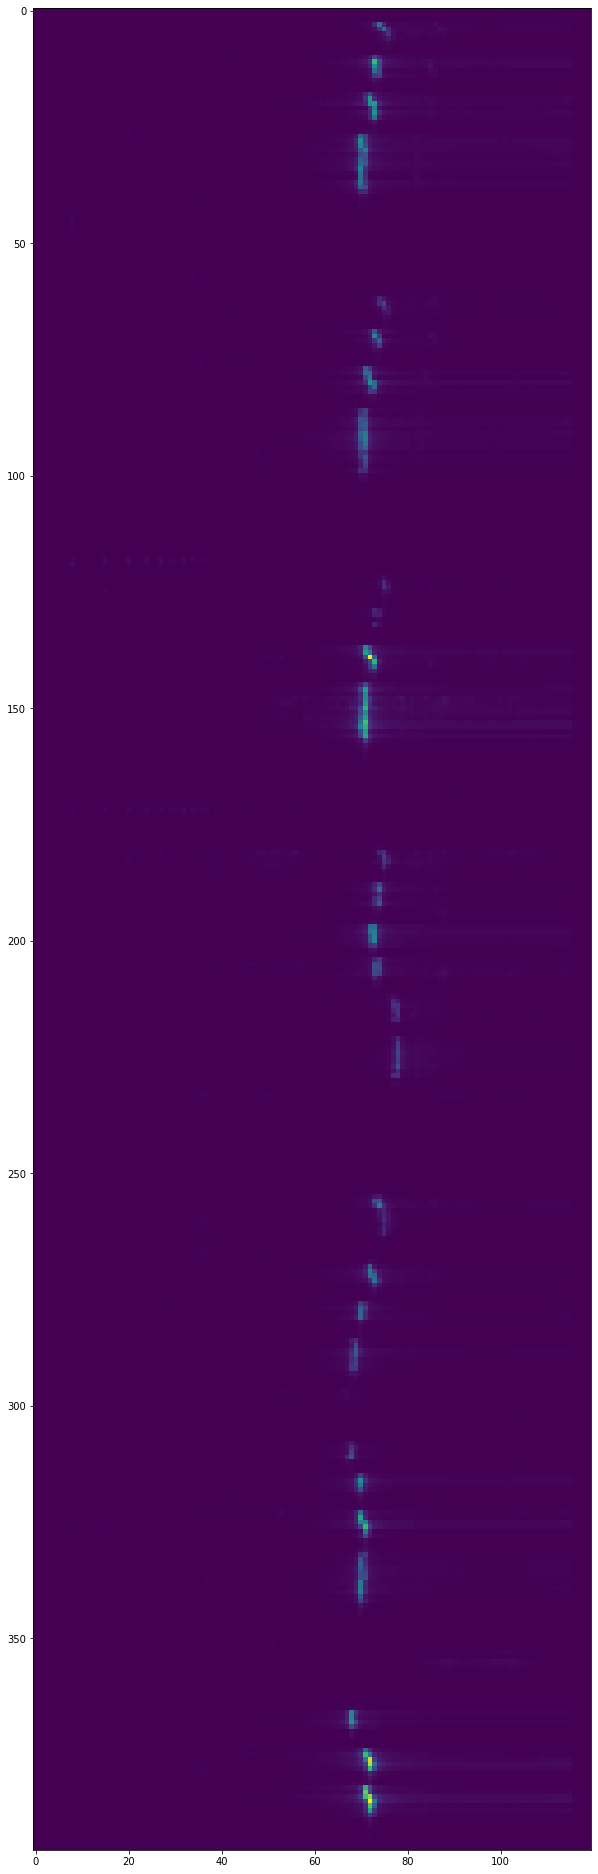

In [308]:
fig, ax = plt.subplots(figsize=(10,100))
im = ax.imshow(song)

In [307]:
for i in range(len(song)):
    for j in range(len(song[i])):
        assert abs(song[i][j] - song2[i][j]) < 1e-8

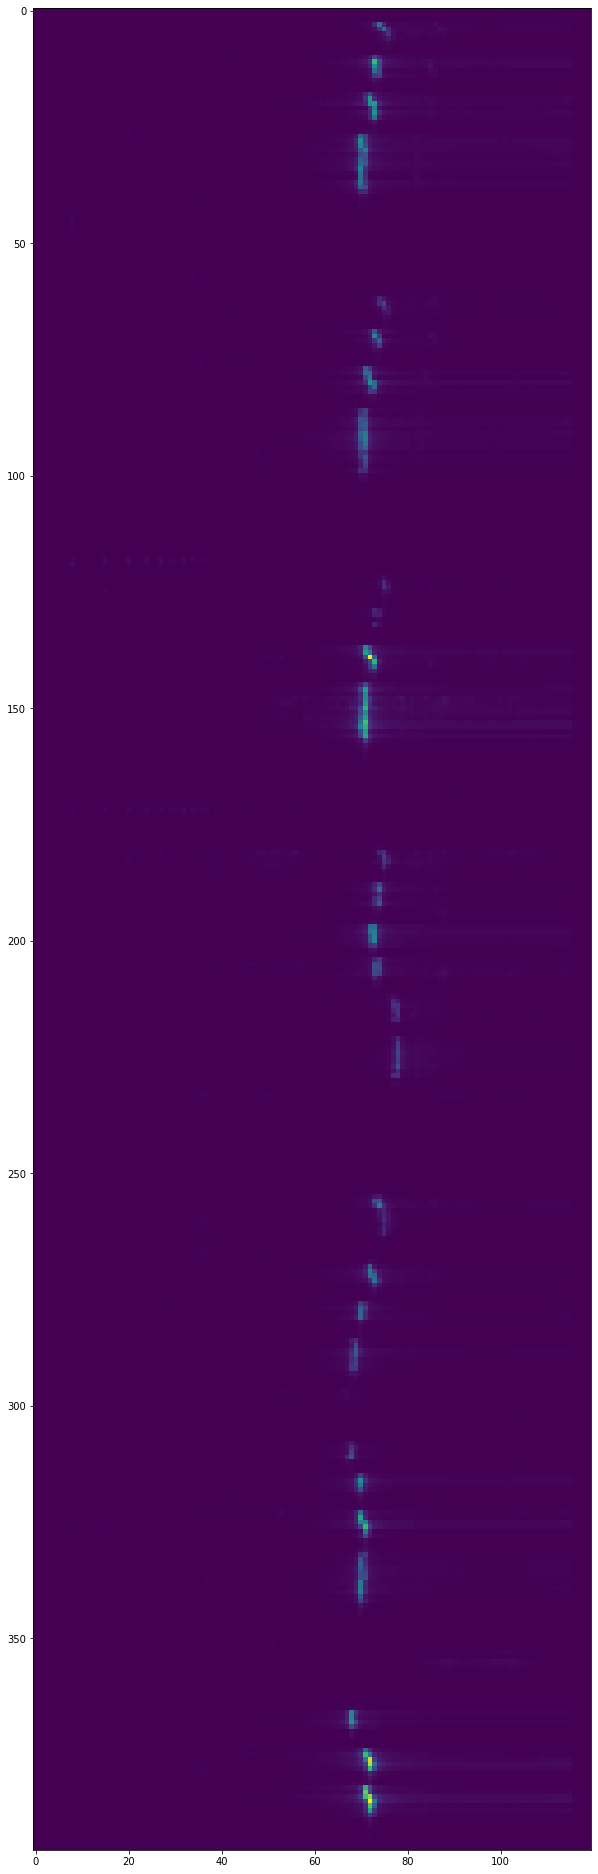

In [309]:
fig, ax = plt.subplots(figsize=(10,100))
im = ax.imshow(song2)